In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 741
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  HS78Q8CD_07_03_00
NN-MODEL FILENAME:  ./models/HS78Q8CD_07_03_00_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, p_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = boundary
    
    
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)

    my_borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = p_table
    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, my_borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, my_borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)

#     GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    new_max = np.array([exp_rec[:,i].max() for i in range(N_STATES)])
    new_min = np.array([exp_rec[:,i].min() for i in range(N_STATES)])
    

    if iteration >= 4: 

        old_max = np.array(boundary[:4])
        old_min = np.array(boundary[4:])

        newboundary_max = old_max
        newboundary_min = old_min

        damper = 0.6
        for i in range(N_STATES):
            newboundary_max[i] = new_max[i] if new_max[i] >= old_max[i] else (old_max[i]*damper+new_max[i]*(1-damper))
            newboundary_min[i] = new_min[i] if new_min[i] <= old_min[i] else (old_min[i]*damper+new_min[i]*(1-damper))
            
            MARGIN = 2*(newboundary_max - newboundary_min)/HI_GRAIN

        newboundary = np.concatenate((newboundary_max + MARGIN,
                                      newboundary_min - MARGIN))
    else:
        MARGIN = 2*(new_max - new_min)/HI_GRAIN
        newboundary = np.concatenate((new_max + MARGIN,
                                      new_min + MARGIN))

        
#   # CLAMP STATE VALUE BORDERS
    ##############################################
    newboundary[0] = clamp(C_POS_ABS_MIN, newboundary[0], C_POS_ABS_MAX)
    newboundary[4] = clamp(C_POS_ABS_MIN, newboundary[4], C_POS_ABS_MAX) 

    newboundary[1] = clamp(C_VEL_ABS_MIN, newboundary[1], C_VEL_ABS_MAX)
    newboundary[5] = clamp(C_VEL_ABS_MIN, newboundary[5], C_VEL_ABS_MAX) 

    newboundary[2] = clamp(P_ANG_ABS_MIN, newboundary[2], P_ANG_ABS_MAX)
    newboundary[6] = clamp(P_ANG_ABS_MIN, newboundary[6], P_ANG_ABS_MAX) 

    newboundary[3] = clamp(P_VEL_ABS_MIN, newboundary[3], P_VEL_ABS_MAX)
    newboundary[7] = clamp(P_VEL_ABS_MIN, newboundary[7], P_VEL_ABS_MAX)
    
#     newboundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
#                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1256.32 MiB, increment: 1036.44 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table
q_table_list = [node_q_table]* NO_OF_NODES




ITERATION # 0
TOTAL EXPERIENCE GENERATED:   13564
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 46
TOTAL SERIAL TIMESTEPS:   13564
TOTAL PARALLEL TIMESTEPS: 46


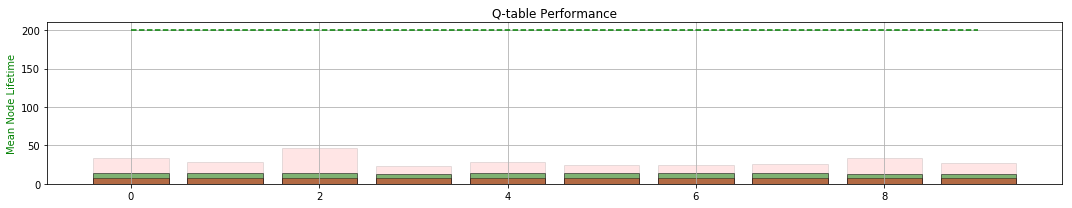

MEMORY COUNTER:  13564
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 670.059	LOSS : 597.176	LOSS : 571.106	LOSS : 587.948	LOSS : 557.282	LOSS : 560.053	LOSS : 560.552	LOSS : 546.854	LOSS : 547.518	LOSS : 549.678	LOSS : 539.268	LOSS : 543.082	LOSS : 531.612	LOSS : 517.937	LOSS : 514.086	LOSS : 510.245	LOSS : 513.494	LOSS : 523.680	LOSS : 498.405	LOSS : 496.337	
Validating... MEAN TIME:  94.815
LOSS : 496.460	LOSS : 504.150	LOSS : 482.099	LOSS : 475.896	LOSS : 469.915	LOSS : 486.066	LOSS : 482.009	LOSS : 472.458	LOSS : 470.097	LOSS : 466.027	LOSS : 462.378	LOSS : 472.685	LOSS : 465.002	LOSS : 467.293	LOSS : 472.711	LOSS : 475.057	LOSS : 456.361	LOSS : 486.361	LOSS : 477.160	LOSS : 459.285	
Validating... MEAN TIME:  98.835
LOSS : 454.968	LOSS : 477.633	LOSS : 473.425	LOSS : 465.397	LOSS : 463.978	LOSS : 484.260	LOSS : 479.922	LOSS : 479.595	LOSS : 483.838	LOSS : 484.216	LOSS : 488.429	LOSS : 489.362	LOSS : 475.851	LOSS : 495.619	LOSS : 472.197	LOSS : 493.762	LOSS : 505

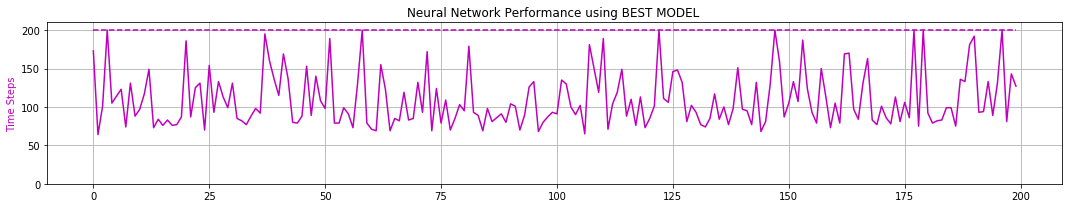

0 -max- [ 0.358  3.146  0.228  3.221]
0 -min- [-0.205 -1.715 -0.188 -3.099]

peak memory: 1313.96 MiB, increment: 1035.23 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.221  2.113  0.230  2.992]
1 -min- [-0.168 -1.591 -0.188 -2.471]

peak memory: 1353.12 MiB, increment: 1035.16 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.243  2.165  0.227  3.034]
2 -min- [-0.169 -1.718 -0.188 -2.682]

peak memory: 1333.30 MiB, increment: 995.79 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.236  2.103  0.230  3.038]
3 -min- [-0.182 -1.569 -0.188 -2.660]

peak memory: 1392.06 MiB, increment: 1034.87 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.251  1.920  0.229  2.961]
4 -min- [-0.154 -1.618 -0.186 -2.471]

peak memory: 1411.44 MiB, increment: 1034.56 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.233  2.169  0.230  3.016]
5 -min- [-0.178 -1.605 -0.188 -2.505]

peak memory: 1431.20 MiB, increment: 1035.16 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.241  1.959  0.229  2.967]
6 -min- [

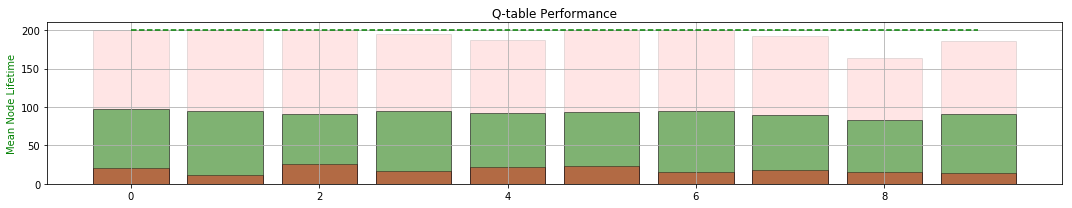

MEMORY COUNTER:  105677
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 603.265	LOSS : 593.125	LOSS : 524.892	LOSS : 485.056	LOSS : 453.910	LOSS : 414.429	LOSS : 376.243	LOSS : 326.234	LOSS : 315.498	LOSS : 278.067	LOSS : 273.287	LOSS : 244.954	LOSS : 253.060	LOSS : 245.809	LOSS : 235.615	LOSS : 220.786	LOSS : 220.674	LOSS : 202.761	LOSS : 210.641	LOSS : 221.711	
Validating... MEAN TIME:  128.815
LOSS : 209.289	LOSS : 208.300	LOSS : 207.548	LOSS : 209.991	LOSS : 202.946	LOSS : 216.953	LOSS : 204.846	LOSS : 213.344	LOSS : 214.334	LOSS : 220.639	LOSS : 212.284	LOSS : 213.002	LOSS : 207.971	LOSS : 233.364	LOSS : 210.725	LOSS : 217.744	LOSS : 216.043	LOSS : 217.064	LOSS : 206.074	LOSS : 214.232	
Validating... MEAN TIME:  112.63
LOSS : 217.643	LOSS : 210.565	LOSS : 222.818	LOSS : 228.842	LOSS : 218.112	LOSS : 223.076	LOSS : 227.743	LOSS : 205.030	LOSS : 216.275	LOSS : 215.585	LOSS : 241.068	LOSS : 230.222	LOSS : 226.921	LOSS : 217.688	LOSS : 222.166	LOSS : 230.335	LOSS : 2

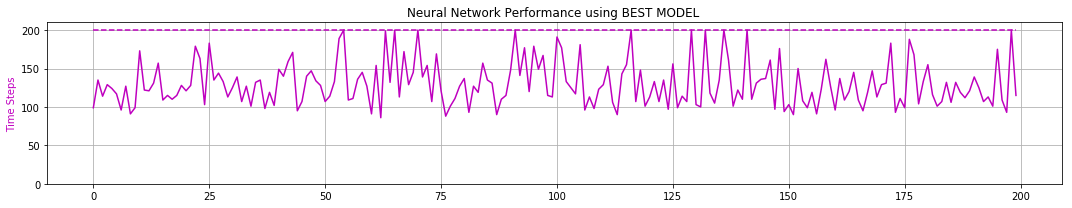

0 -max- [ 0.647  1.504  0.230  1.822]
0 -min- [-0.593 -1.537 -0.188 -1.917]

peak memory: 1584.18 MiB, increment: 1059.77 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.570  1.489  0.230  1.860]
1 -min- [-0.507 -1.525 -0.188 -1.711]

peak memory: 1574.93 MiB, increment: 1016.09 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.593  1.499  0.230  1.654]
2 -min- [-0.532 -1.396 -0.188 -1.575]

peak memory: 1594.46 MiB, increment: 1016.20 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.733  1.652  0.230  1.888]
3 -min- [-0.540 -1.352 -0.189 -1.485]

peak memory: 1607.54 MiB, increment: 1009.60 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.604  1.532  0.230  1.994]
4 -min- [-0.598 -1.559 -0.188 -1.752]

peak memory: 1652.50 MiB, increment: 1034.76 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.768  1.885  0.230  2.297]
5 -min- [-0.567 -1.535 -0.188 -1.493]

peak memory: 1672.09 MiB, increment: 1034.93 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.734  1.628  0.230  1.901]
6 -min- 

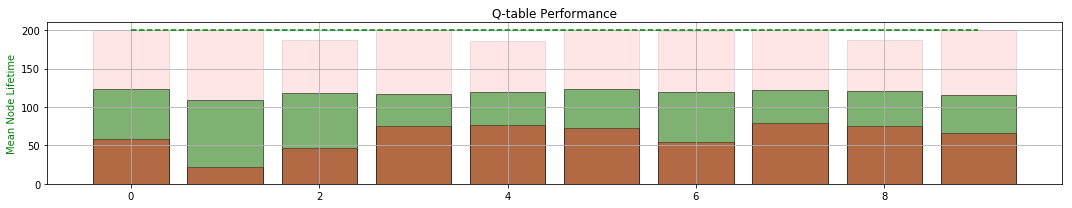

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 133.723	LOSS : 132.969	LOSS : 125.132	LOSS : 114.263	LOSS : 109.715	LOSS : 109.624	LOSS : 106.592	LOSS : 111.566	LOSS : 108.547	LOSS : 112.844	LOSS : 109.933	LOSS : 114.619	LOSS : 104.555	LOSS : 106.656	LOSS : 96.112	LOSS : 89.654	LOSS : 96.473	LOSS : 105.337	LOSS : 92.826	LOSS : 98.965	
Validating... MEAN TIME:  187.885
LOSS : 95.511	LOSS : 104.837	LOSS : 95.269	LOSS : 91.241	LOSS : 97.914	LOSS : 97.583	LOSS : 91.622	LOSS : 86.544	LOSS : 92.981	LOSS : 93.864	LOSS : 99.079	LOSS : 90.395	LOSS : 88.398	LOSS : 97.921	LOSS : 95.414	LOSS : 88.135	LOSS : 90.412	LOSS : 87.998	LOSS : 86.360	LOSS : 88.743	
Validating... MEAN TIME:  194.31
LOSS : 91.235	LOSS : 92.917	LOSS : 89.392	LOSS : 92.758	LOSS : 86.436	LOSS : 91.147	LOSS : 96.007	LOSS : 85.849	LOSS : 90.713	LOSS : 95.714	LOSS : 83.634	LOSS : 86.508	LOSS : 89.992	LOSS : 87.150	LOSS : 82.414	LOSS : 83.220	LOSS : 84.094	LOSS : 93.813	LOSS : 89.217	LOSS :

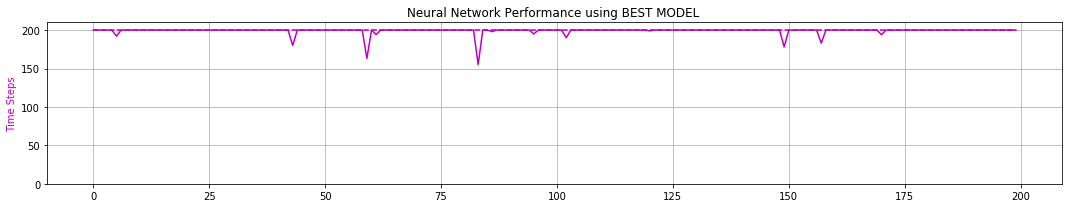

0 -max- [ 0.862  1.661  0.230  1.569]
0 -min- [-0.795 -1.675 -0.188 -1.157]

peak memory: 1694.08 MiB, increment: 971.32 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.890  1.499  0.230  1.646]
1 -min- [-0.855 -1.645 -0.189 -1.536]

peak memory: 1699.73 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.913  1.805  0.230  1.499]
2 -min- [-0.849 -1.677 -0.189 -1.767]

peak memory: 1699.73 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.916  1.694  0.230  1.616]
3 -min- [-0.887 -1.699 -0.188 -1.344]

peak memory: 1699.73 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.922  1.875  0.230  1.291]
4 -min- [-0.853 -1.658 -0.188 -1.170]

peak memory: 1699.73 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.930  1.650  0.230  1.686]
5 -min- [-0.955 -2.060 -0.188 -1.442]

peak memory: 1738.66 MiB, increment: 977.00 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.960  1.637  0.230  1.608]
6 -min- [-0.82

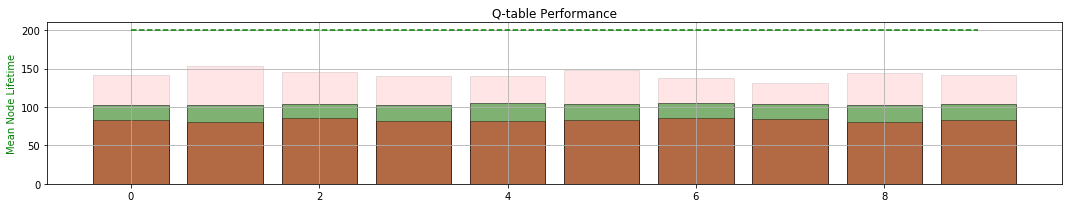

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 100.899	LOSS : 82.997	LOSS : 70.534	LOSS : 72.209	LOSS : 67.735	LOSS : 79.633	LOSS : 74.948	LOSS : 70.542	LOSS : 71.376	LOSS : 71.694	LOSS : 74.830	LOSS : 73.016	LOSS : 71.330	LOSS : 72.931	LOSS : 75.340	LOSS : 76.377	LOSS : 74.850	LOSS : 78.856	LOSS : 70.891	LOSS : 73.238	
Validating... MEAN TIME:  150.55
LOSS : 73.713	LOSS : 75.267	LOSS : 78.919	LOSS : 70.067	LOSS : 73.714	LOSS : 75.444	LOSS : 78.572	LOSS : 70.172	LOSS : 77.514	LOSS : 89.321	LOSS : 82.922	LOSS : 78.597	LOSS : 74.891	LOSS : 74.948	LOSS : 79.638	LOSS : 74.431	LOSS : 81.300	LOSS : 72.625	LOSS : 76.788	LOSS : 79.966	
Validating... MEAN TIME:  168.425
LOSS : 76.814	LOSS : 74.626	LOSS : 73.171	LOSS : 80.190	LOSS : 76.184	LOSS : 79.365	LOSS : 69.446	LOSS : 78.322	LOSS : 77.217	LOSS : 80.712	LOSS : 79.986	LOSS : 73.260	LOSS : 73.066	LOSS : 70.476	LOSS : 71.187	LOSS : 74.095	LOSS : 72.146	LOSS : 77.616	LOSS : 77.219	LOSS : 70.505	
Valida

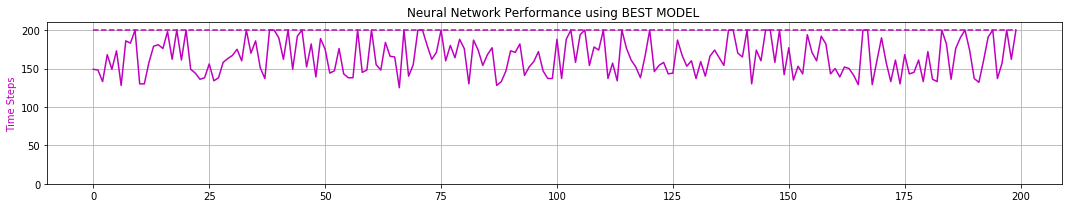

0 -max- [ 0.199  0.713  0.061  0.781]
0 -min- [-0.893 -1.545 -0.197 -0.943]

peak memory: 1797.84 MiB, increment: 977.05 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.204  0.726  0.063  0.768]
1 -min- [-0.920 -1.554 -0.196 -1.006]

peak memory: 1797.84 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.180  0.737  0.062  0.759]
2 -min- [-0.936 -1.682 -0.196 -0.974]

peak memory: 1797.84 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.222  0.547  0.062  0.759]
3 -min- [-1.029 -1.701 -0.196 -0.957]

peak memory: 1797.84 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.212  0.741  0.064  0.774]
4 -min- [-0.980 -1.547 -0.196 -0.819]

peak memory: 1797.84 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.198  0.544  0.062  0.783]
5 -min- [-0.893 -1.550 -0.196 -0.950]

peak memory: 1797.84 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.213  0.542  0.063  0.769]
6 -min- [-0.91

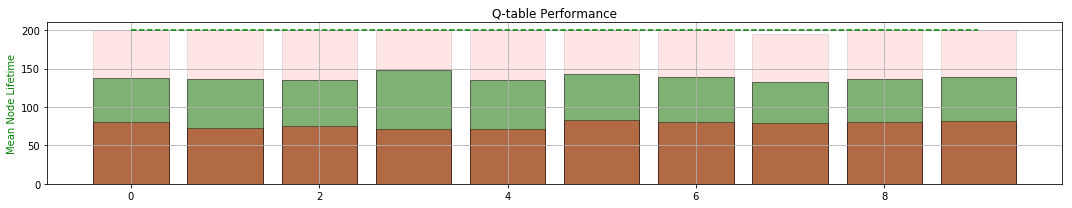

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 105.005	LOSS : 101.330	LOSS : 94.909	LOSS : 94.830	LOSS : 90.962	LOSS : 106.027	LOSS : 106.746	LOSS : 108.872	LOSS : 96.549	LOSS : 99.073	LOSS : 100.779	LOSS : 94.787	LOSS : 110.286	LOSS : 105.765	LOSS : 107.797	LOSS : 102.100	LOSS : 94.578	LOSS : 105.676	LOSS : 91.454	LOSS : 102.972	
Validating... MEAN TIME:  163.27
LOSS : 94.096	LOSS : 92.460	LOSS : 91.339	LOSS : 95.446	LOSS : 98.260	LOSS : 107.102	LOSS : 94.088	LOSS : 96.323	LOSS : 95.122	LOSS : 107.919	LOSS : 101.418	LOSS : 92.647	LOSS : 90.358	LOSS : 98.445	LOSS : 110.144	LOSS : 97.483	LOSS : 103.537	LOSS : 106.454	LOSS : 86.963	LOSS : 99.030	
Validating... MEAN TIME:  110.225
LOSS : 104.056	LOSS : 98.699	LOSS : 104.074	LOSS : 101.476	LOSS : 97.439	LOSS : 92.103	LOSS : 97.164	LOSS : 93.782	LOSS : 78.310	LOSS : 83.794	LOSS : 88.212	LOSS : 91.144	LOSS : 101.193	LOSS : 99.323	LOSS : 109.721	LOSS : 92.309	LOSS : 83.971	LOSS : 96.540	LOSS : 80.303

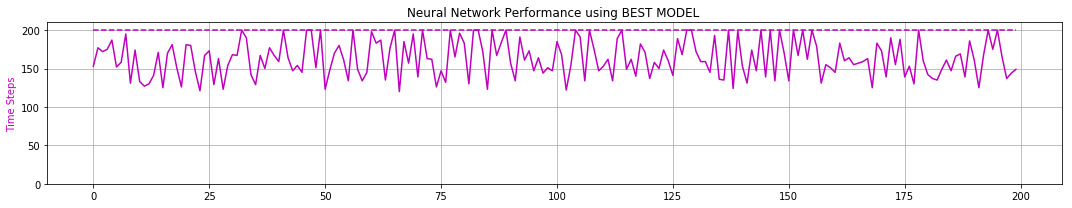

0 -max- [ 2.600  4.353  0.250  4.547]
0 -min- [-2.600 -4.669 -0.250 -4.526]

peak memory: 1730.83 MiB, increment: 976.84 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 2.600  4.359  0.250  4.515]
1 -min- [-2.600 -4.673 -0.250 -4.535]

peak memory: 1847.89 MiB, increment: 976.95 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 2.539  4.289  0.250  4.504]
2 -min- [-2.600 -4.655 -0.250 -4.540]

peak memory: 1769.77 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 2.600  4.367  0.250  4.514]
3 -min- [-2.600 -4.675 -0.250 -4.539]

peak memory: 1828.49 MiB, increment: 976.91 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 2.569  4.298  0.250  4.502]
4 -min- [-2.600 -4.643 -0.250 -4.566]

peak memory: 1828.49 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 2.590  4.347  0.250  4.469]
5 -min- [-2.600 -4.668 -0.250 -4.531]

peak memory: 1847.89 MiB, increment: 976.87 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 2.600  4.374  0.250  4.554]
6 -min- [-2.60

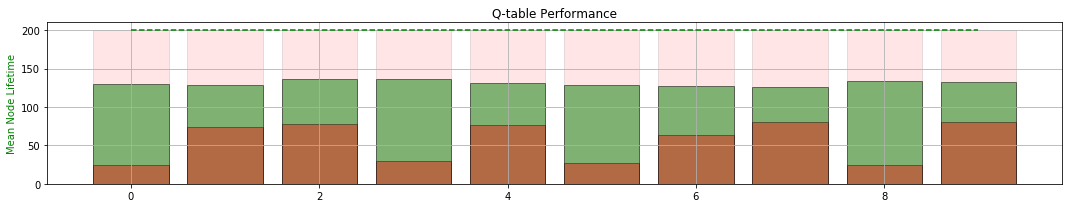

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 87.689	LOSS : 89.192	LOSS : 86.954	LOSS : 82.344	LOSS : 83.357	LOSS : 86.084	LOSS : 85.029	LOSS : 84.614	LOSS : 69.512	LOSS : 76.421	LOSS : 77.724	LOSS : 84.451	LOSS : 80.593	LOSS : 91.074	LOSS : 73.011	LOSS : 87.836	LOSS : 85.752	LOSS : 82.309	LOSS : 87.216	LOSS : 78.257	
Validating... MEAN TIME:  104.89
LOSS : 85.393	LOSS : 80.066	LOSS : 81.162	LOSS : 81.113	LOSS : 87.573	LOSS : 71.836	LOSS : 81.090	LOSS : 82.137	LOSS : 79.405	LOSS : 80.883	LOSS : 87.479	LOSS : 81.696	LOSS : 74.597	LOSS : 84.261	LOSS : 71.000	LOSS : 79.185	LOSS : 82.599	LOSS : 77.913	LOSS : 80.065	LOSS : 89.140	
Validating... MEAN TIME:  106.785
LOSS : 80.732	LOSS : 73.111	LOSS : 77.953	LOSS : 83.486	LOSS : 77.498	LOSS : 92.025	LOSS : 73.088	LOSS : 86.584	LOSS : 81.650	LOSS : 80.791	LOSS : 86.465	LOSS : 74.493	LOSS : 81.245	LOSS : 76.208	LOSS : 81.285	LOSS : 80.966	LOSS : 80.162	LOSS : 85.101	LOSS : 87.735	LOSS : 72.355	
Validat

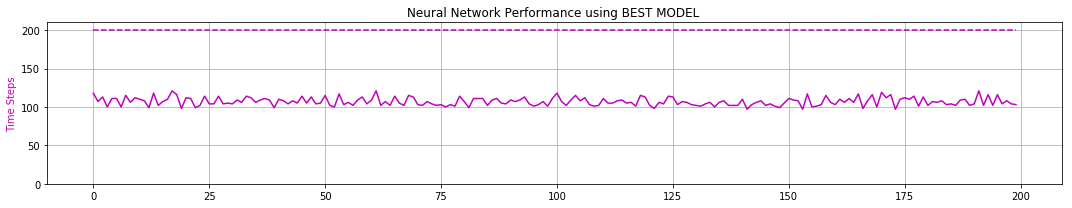

0 -max- [ 2.600  4.009  0.250  3.943]
0 -min- [-2.597 -4.211 -0.250 -3.580]

peak memory: 1870.23 MiB, increment: 976.90 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 2.600  4.088  0.250  3.900]
1 -min- [-2.600 -4.301 -0.250 -3.583]

peak memory: 1948.36 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 2.600  3.970  0.250  3.812]
2 -min- [-2.600 -4.342 -0.250 -3.622]

peak memory: 1944.86 MiB, increment: 973.07 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 2.600  4.023  0.250  3.887]
3 -min- [-2.600 -4.415 -0.250 -3.550]

peak memory: 1948.36 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 2.600  3.993  0.250  3.782]
4 -min- [-2.600 -4.410 -0.250 -3.565]

peak memory: 1943.34 MiB, increment: 971.55 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 2.600  4.077  0.250  3.885]
5 -min- [-2.600 -4.295 -0.250 -3.511]

peak memory: 1948.36 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 2.600  4.041  0.250  3.841]
6 -min- [-2.60

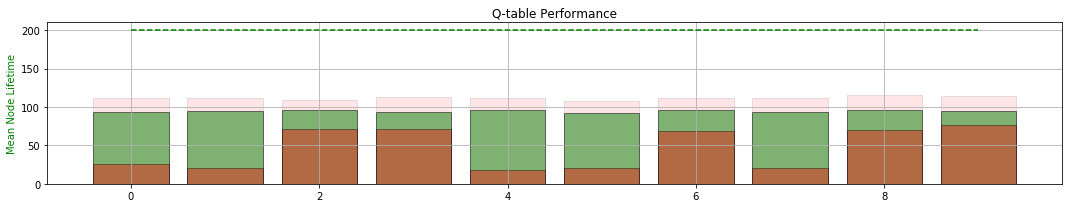

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 147.272	LOSS : 130.669	LOSS : 132.901	LOSS : 145.475	LOSS : 121.023	LOSS : 133.522	LOSS : 130.853	LOSS : 123.365	LOSS : 134.605	LOSS : 125.933	LOSS : 127.261	LOSS : 114.183	LOSS : 116.459	LOSS : 110.495	LOSS : 119.010	LOSS : 120.832	LOSS : 112.671	LOSS : 112.451	LOSS : 109.177	LOSS : 110.135	
Validating... MEAN TIME:  141.795
LOSS : 115.682	LOSS : 110.659	LOSS : 112.794	LOSS : 107.285	LOSS : 125.823	LOSS : 121.015	LOSS : 115.393	LOSS : 114.084	LOSS : 115.388	LOSS : 125.908	LOSS : 119.367	LOSS : 119.451	LOSS : 133.162	LOSS : 111.706	LOSS : 128.733	LOSS : 128.019	LOSS : 116.768	LOSS : 135.172	LOSS : 106.765	LOSS : 127.239	
Validating... MEAN TIME:  164.88
LOSS : 120.402	LOSS : 110.020	LOSS : 113.663	LOSS : 112.907	LOSS : 111.144	LOSS : 117.504	LOSS : 132.056	LOSS : 119.613	LOSS : 111.830	LOSS : 113.761	LOSS : 126.091	LOSS : 121.094	LOSS : 132.890	LOSS : 106.103	LOSS : 115.459	LOSS : 116.838	LOSS : 1

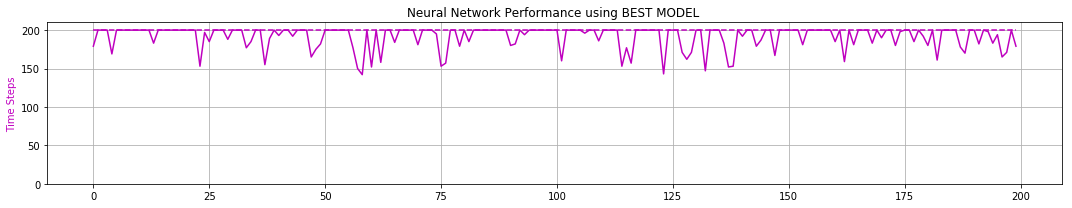

0 -max- [ 1.847  2.976  0.190  3.105]
0 -min- [-2.600 -4.112 -0.250 -2.818]

peak memory: 1870.38 MiB, increment: 976.96 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.837  3.038  0.191  3.059]
1 -min- [-2.600 -4.219 -0.250 -2.879]

peak memory: 1948.51 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.837  2.964  0.190  3.032]
2 -min- [-2.600 -4.253 -0.250 -2.845]

peak memory: 1870.38 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.842  2.996  0.190  3.001]
3 -min- [-2.600 -4.239 -0.250 -2.834]

peak memory: 1948.51 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.834  2.979  0.190  3.012]
4 -min- [-2.600 -4.234 -0.250 -2.894]

peak memory: 1948.51 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.842  3.081  0.190  3.047]
5 -min- [-2.600 -4.237 -0.250 -2.818]

peak memory: 1948.51 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.830  3.050  0.190  2.996]
6 -min- [-2.60

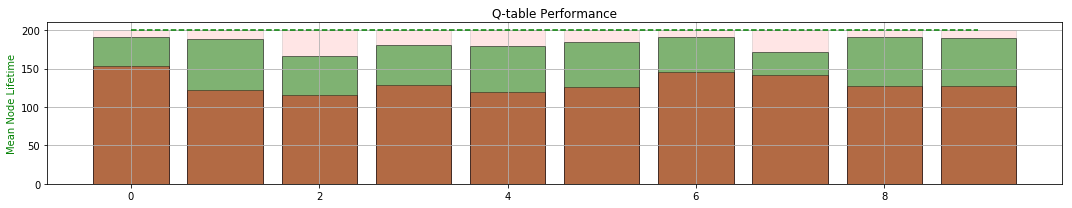

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 86.776	LOSS : 75.712	LOSS : 79.196	LOSS : 64.847	LOSS : 70.699	LOSS : 69.289	LOSS : 78.027	LOSS : 51.111	LOSS : 62.853	LOSS : 70.079	LOSS : 71.274	LOSS : 66.307	LOSS : 62.706	LOSS : 70.765	LOSS : 64.425	LOSS : 60.393	LOSS : 66.755	LOSS : 52.864	LOSS : 64.864	LOSS : 52.306	
Validating... MEAN TIME:  115.265
LOSS : 55.311	LOSS : 64.664	LOSS : 65.627	LOSS : 58.466	LOSS : 64.642	LOSS : 65.323	LOSS : 60.366	LOSS : 66.091	LOSS : 55.778	LOSS : 61.150	LOSS : 67.841	LOSS : 54.002	LOSS : 55.434	LOSS : 66.359	LOSS : 57.305	LOSS : 75.552	LOSS : 58.429	LOSS : 62.182	LOSS : 68.226	LOSS : 56.346	
Validating... MEAN TIME:  115.195
LOSS : 57.510	LOSS : 64.704	LOSS : 67.910	LOSS : 64.843	LOSS : 60.256	LOSS : 65.922	LOSS : 61.152	LOSS : 59.671	LOSS : 54.767	LOSS : 57.452	LOSS : 68.494	LOSS : 63.000	LOSS : 61.123	LOSS : 63.293	LOSS : 59.012	LOSS : 59.286	LOSS : 55.975	LOSS : 60.171	LOSS : 63.311	LOSS : 60.297	
Valida

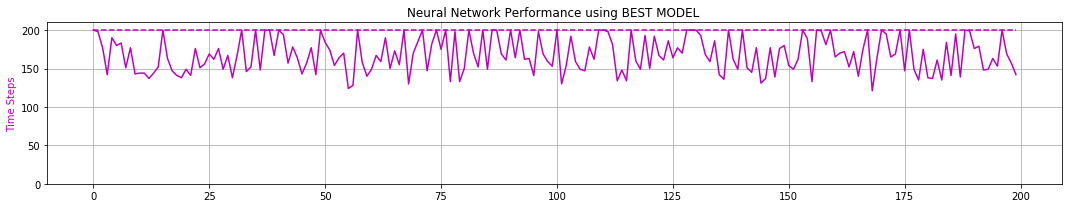

0 -max- [ 2.600  3.218  0.212  2.450]
0 -min- [-2.600 -3.944 -0.250 -2.270]

peak memory: 1909.15 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 2.600  3.254  0.211  2.421]
1 -min- [-2.600 -4.034 -0.250 -2.366]

peak memory: 1909.15 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 2.600  3.219  0.218  2.416]
2 -min- [-2.498 -3.838 -0.250 -2.343]

peak memory: 1907.87 MiB, increment: 975.29 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 2.600  3.251  0.212  2.549]
3 -min- [-2.600 -4.054 -0.250 -2.342]

peak memory: 1909.15 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 2.600  3.288  0.221  2.475]
4 -min- [-2.600 -4.055 -0.250 -2.520]

peak memory: 1909.15 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 2.600  3.263  0.212  2.445]
5 -min- [-2.138 -3.436 -0.250 -2.304]

peak memory: 1831.02 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 2.600  3.262  0.223  2.350]
6 -min- [-2.45

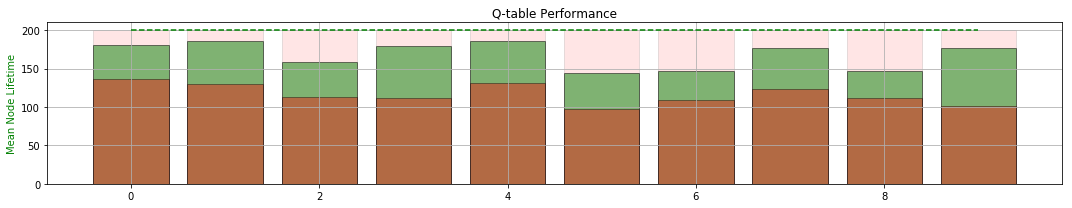

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 56.370	LOSS : 57.836	LOSS : 58.751	LOSS : 57.268	LOSS : 59.662	LOSS : 54.446	LOSS : 57.729	LOSS : 63.986	LOSS : 62.001	LOSS : 64.772	LOSS : 61.233	LOSS : 60.161	LOSS : 63.325	LOSS : 70.665	LOSS : 63.269	LOSS : 69.926	LOSS : 68.568	LOSS : 79.466	LOSS : 75.090	LOSS : 46.741	
Validating... MEAN TIME:  128.49
LOSS : 64.850	LOSS : 74.086	LOSS : 66.808	LOSS : 68.588	LOSS : 66.353	LOSS : 61.436	LOSS : 69.343	LOSS : 52.370	LOSS : 63.745	LOSS : 58.034	LOSS : 61.548	LOSS : 62.631	LOSS : 65.876	LOSS : 67.727	LOSS : 65.397	LOSS : 69.909	LOSS : 61.698	LOSS : 62.941	LOSS : 58.240	LOSS : 59.999	
Validating... MEAN TIME:  129.83
LOSS : 59.816	LOSS : 65.923	LOSS : 63.422	LOSS : 56.518	LOSS : 57.168	LOSS : 56.418	LOSS : 63.391	LOSS : 63.083	LOSS : 58.537	LOSS : 53.268	LOSS : 64.290	LOSS : 61.168	LOSS : 60.274	LOSS : 59.889	LOSS : 67.189	LOSS : 74.729	LOSS : 59.886	LOSS : 56.170	LOSS : 69.758	LOSS : 69.234	
Validati

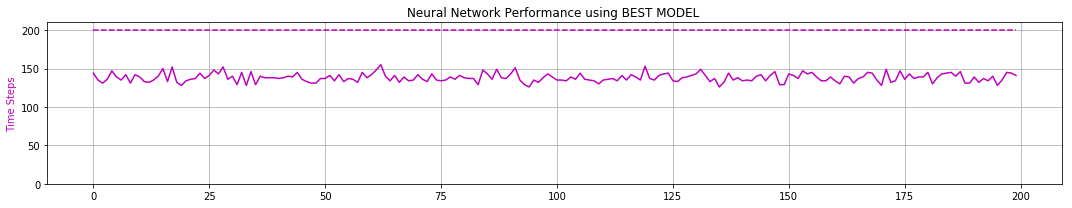

0 -max- [ 2.600  3.302  0.214  2.009]
0 -min- [-2.600 -3.920 -0.250 -2.069]

peak memory: 1915.71 MiB, increment: 976.83 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 2.600  3.294  0.216  1.983]
1 -min- [-2.600 -4.004 -0.250 -2.049]

peak memory: 1993.84 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 2.600  3.363  0.222  2.014]
2 -min- [-2.600 -3.899 -0.250 -1.995]

peak memory: 1915.71 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 2.600  3.330  0.216  2.078]
3 -min- [-2.600 -4.017 -0.250 -2.206]

peak memory: 1915.71 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 2.600  3.378  0.227  2.050]
4 -min- [-2.522 -3.782 -0.250 -2.107]

peak memory: 1915.71 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 2.600  3.394  0.220  2.000]
5 -min- [-2.596 -3.564 -0.250 -1.968]

peak memory: 1993.84 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 2.600  3.390  0.226  1.946]
6 -min- [-2.60

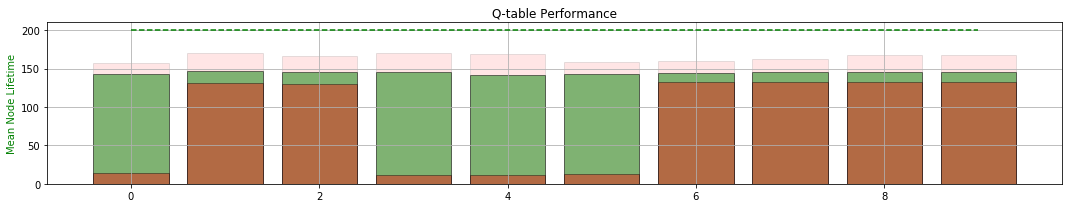

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 54.055	LOSS : 73.905	LOSS : 66.929	LOSS : 68.975	LOSS : 60.271	LOSS : 58.353	LOSS : 68.394	LOSS : 65.766	LOSS : 60.519	LOSS : 57.967	LOSS : 51.926	LOSS : 56.160	LOSS : 53.094	LOSS : 59.213	LOSS : 56.232	LOSS : 59.588	LOSS : 72.784	LOSS : 64.411	LOSS : 61.922	LOSS : 61.325	
Validating... MEAN TIME:  164.125
LOSS : 64.740	LOSS : 57.940	LOSS : 54.277	LOSS : 59.597	LOSS : 61.796	LOSS : 55.686	LOSS : 70.771	LOSS : 62.720	LOSS : 70.510	LOSS : 57.923	LOSS : 56.941	LOSS : 58.812	LOSS : 58.724	LOSS : 59.874	LOSS : 59.363	LOSS : 56.725	LOSS : 68.956	LOSS : 60.633	LOSS : 52.829	LOSS : 50.877	
Validating... MEAN TIME:  134.45
LOSS : 53.483	LOSS : 56.422	LOSS : 55.490	LOSS : 58.932	LOSS : 61.050	LOSS : 58.000	LOSS : 58.857	LOSS : 67.560	LOSS : 65.350	LOSS : 65.163	LOSS : 64.938	LOSS : 49.910	LOSS : 55.283	LOSS : 58.208	LOSS : 67.311	LOSS : 55.094	LOSS : 63.258	LOSS : 56.305	LOSS : 57.831	LOSS : 64.230	
Validat

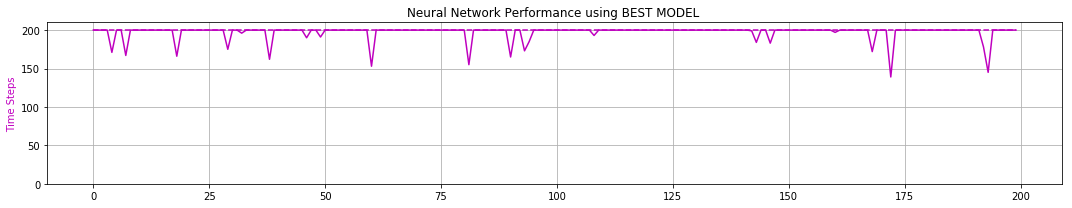

0 -max- [ 2.600  3.545  0.231  2.053]
0 -min- [-1.819 -3.119 -0.189 -1.971]

peak memory: 1843.24 MiB, increment: 976.89 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 2.600  3.641  0.232  2.010]
1 -min- [-1.820 -3.112 -0.188 -2.006]

peak memory: 1843.24 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 2.600  3.571  0.236  1.984]
2 -min- [-1.825 -3.049 -0.188 -1.862]

peak memory: 1843.24 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 2.600  3.573  0.232  2.264]
3 -min- [-1.830 -3.271 -0.190 -2.111]

peak memory: 1784.13 MiB, increment: 995.59 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 2.600  3.513  0.238  2.217]
4 -min- [-1.799 -3.122 -0.189 -1.907]

peak memory: 1882.18 MiB, increment: 977.07 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 2.600  3.593  0.235  2.085]
5 -min- [-1.843 -2.919 -0.189 -1.883]

peak memory: 1823.35 MiB, increment: 995.87 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 2.600  3.606  0.238  2.013]
6 -min- [-1.82

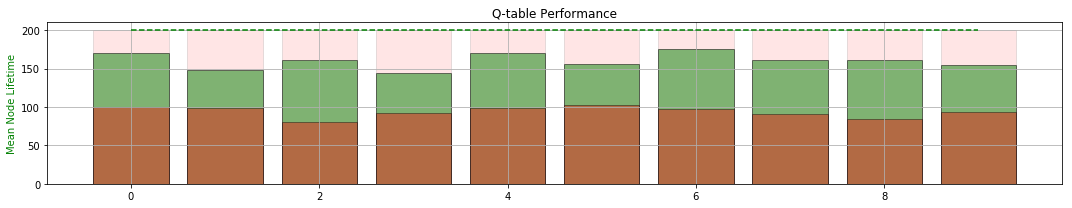

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 65.706	LOSS : 62.943	LOSS : 70.179	LOSS : 66.099	LOSS : 64.862	LOSS : 59.537	LOSS : 58.558	LOSS : 54.899	LOSS : 57.317	LOSS : 57.037	LOSS : 68.238	LOSS : 68.403	LOSS : 59.130	LOSS : 65.988	LOSS : 61.275	LOSS : 58.434	LOSS : 62.125	LOSS : 59.875	LOSS : 60.979	LOSS : 71.292	
Validating... MEAN TIME:  120.485
LOSS : 60.386	LOSS : 60.244	LOSS : 52.519	LOSS : 63.949	LOSS : 62.064	LOSS : 60.718	LOSS : 62.653	LOSS : 52.565	LOSS : 63.772	LOSS : 67.029	LOSS : 56.142	LOSS : 61.249	LOSS : 67.581	LOSS : 75.132	LOSS : 58.406	LOSS : 73.370	LOSS : 60.494	LOSS : 65.771	LOSS : 59.456	LOSS : 57.772	
Validating... MEAN TIME:  113.3
LOSS : 55.507	LOSS : 60.308	LOSS : 66.852	LOSS : 59.577	LOSS : 78.704	LOSS : 67.932	LOSS : 62.667	LOSS : 55.410	LOSS : 65.627	LOSS : 51.924	LOSS : 63.682	LOSS : 57.853	LOSS : 62.939	LOSS : 60.474	LOSS : 68.189	LOSS : 74.112	LOSS : 64.532	LOSS : 65.213	LOSS : 59.799	LOSS : 76.822	
Validati

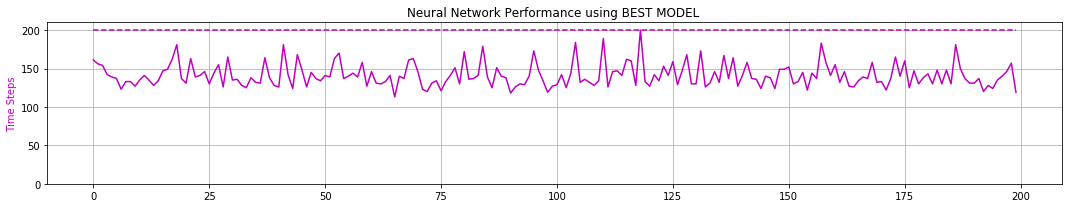

0 -max- [ 2.041  2.652  0.180  1.719]
0 -min- [-2.600 -3.572 -0.228 -1.719]

peak memory: 1882.18 MiB, increment: 976.95 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.980  2.713  0.177  1.704]
1 -min- [-2.564 -3.577 -0.228 -1.782]

peak memory: 1882.18 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.912  2.657  0.180  1.707]
2 -min- [-2.600 -3.530 -0.228 -1.756]

peak memory: 1804.05 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.903  2.674  0.177  1.854]
3 -min- [-2.597 -3.548 -0.228 -1.856]

peak memory: 1921.24 MiB, increment: 976.77 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.901  2.685  0.182  1.841]
4 -min- [-2.600 -3.585 -0.228 -1.688]

peak memory: 1843.11 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.889  2.670  0.179  1.824]
5 -min- [-2.574 -3.550 -0.228 -1.817]

peak memory: 1901.84 MiB, increment: 976.98 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 2.007  2.887  0.188  1.692]
6 -min- [-2.59

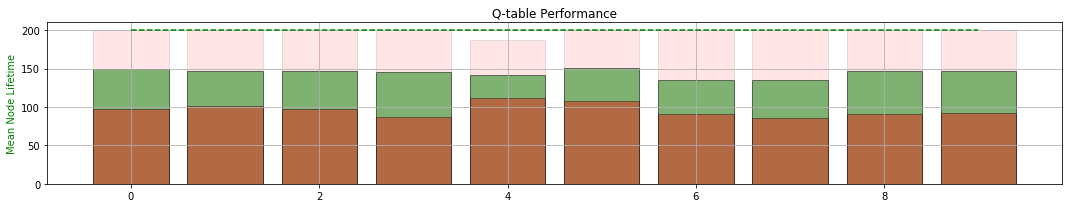

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 85.364	LOSS : 78.898	LOSS : 79.460	LOSS : 83.724	LOSS : 87.106	LOSS : 76.174	LOSS : 85.716	LOSS : 65.789	LOSS : 74.138	LOSS : 74.297	LOSS : 74.693	LOSS : 67.095	LOSS : 72.982	LOSS : 70.611	LOSS : 67.987	LOSS : 66.063	LOSS : 73.249	LOSS : 82.748	LOSS : 80.573	LOSS : 67.997	
Validating... MEAN TIME:  199.67
LOSS : 58.155	LOSS : 75.209	LOSS : 75.731	LOSS : 63.175	LOSS : 74.526	LOSS : 79.241	LOSS : 66.173	LOSS : 66.356	LOSS : 70.469	LOSS : 69.735	LOSS : 79.002	LOSS : 69.499	LOSS : 63.223	LOSS : 73.711	LOSS : 68.108	LOSS : 57.940	LOSS : 70.602	LOSS : 68.852	LOSS : 70.570	LOSS : 69.509	
Validating... MEAN TIME:  199.04
LOSS : 61.579	LOSS : 68.781	LOSS : 54.122	LOSS : 64.669	LOSS : 66.171	LOSS : 68.582	LOSS : 68.363	LOSS : 68.912	LOSS : 56.528	LOSS : 61.208	LOSS : 67.548	LOSS : 69.366	LOSS : 64.811	LOSS : 60.711	LOSS : 67.409	LOSS : 61.192	LOSS : 67.091	LOSS : 74.926	LOSS : 68.313	LOSS : 60.127	
Validati

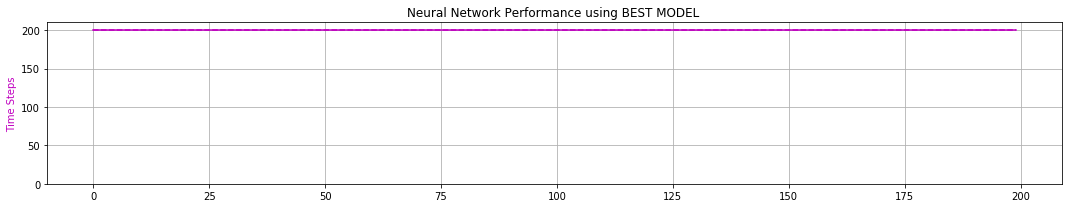

0 -max- [ 1.465  2.156  0.145  1.555]
0 -min- [-2.600 -3.651 -0.238 -1.766]

peak memory: 1901.71 MiB, increment: 977.02 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.818  2.563  0.170  1.607]
1 -min- [-2.600 -3.688 -0.239 -1.714]

peak memory: 1901.71 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.563  2.240  0.165  1.505]
2 -min- [-2.600 -3.623 -0.239 -1.708]

peak memory: 1979.84 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.393  2.163  0.161  1.655]
3 -min- [-2.600 -3.653 -0.238 -1.786]

peak memory: 1979.84 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.372  2.122  0.147  1.570]
4 -min- [-2.600 -3.603 -0.238 -1.669]

peak memory: 1979.84 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.785  2.317  0.172  1.699]
5 -min- [-2.600 -3.637 -0.239 -1.763]

peak memory: 1979.84 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.438  2.302  0.150  1.586]
6 -min- [-2.60

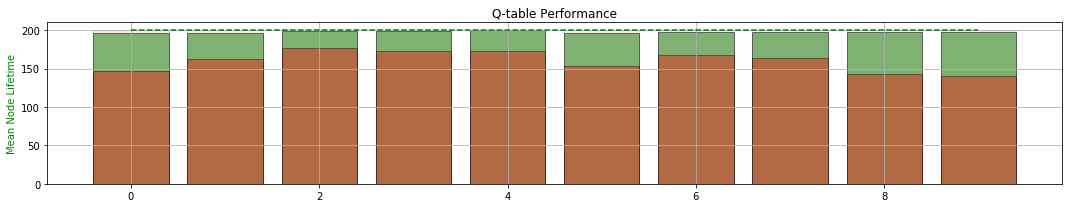

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        

    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    if iteration >= 4:
        for node_id in range(NO_OF_NODES):
            # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")

            # CREATE STATE COMBINATIONS
            ###############################################
            node_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN],
                                                [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX],
                                                [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])
            ###############################################
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    else:
        for node_id in range(NO_OF_NODES):

            # PRINT STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")
            #############################################################################################################################################
            node_state_combinations = init_state_combinations
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
            node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  2284.0
Total Serial Timesteps   :  1690066.0
Speed-up                 :  739.96


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

   741 SUCCESS 140  12    2284    1690066     739.96
